# Data loader
data in /dds/workspace/data_ja/

In [2]:
!ls /dds/work/workspace/data_ja/

CAT_1_9013.jpg	    CAT_1_9024.jpg	RF-CAT1-v1.0.csv
CAT_1_9013.jpg.ppm  CAT_1_9024.jpg.ppm	masks


# IMAGE LOADER

### fonction de chargement d'image jpeg par morceau

In [118]:
from PIL import Image, ImageDraw
Image.MAX_IMAGE_PIXELS = 1e10
# ImageFile.LOAD_TRUNCATED_IMAGES = True

import os.path as osp
import numpy as np
import glob

import errno    
import os


def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and osp.isdir(path):
            pass
        else:
            raise

def change_tile(tile, new_width, new_height, memory_offset):
    tup = tile[0]
    return [(tup[0],) + ((0,0,new_width, new_height),) + (tup[-2]+memory_offset,) + (tup[-1],)]

def read_line_portion(img_path,x,y,w,h,i):
    img_pil = Image.open(img_path)
    W = img_pil.size[0]
    img_pil.size=(w,1)
    memory_offset = (x+i)*3*W+3*y
    img_pil.tile = change_tile(img_pil.tile,w,1,memory_offset)
    #print(img_pil.tile)
    #print(img_pil.size)
    return img_pil

def read_from_memory(img_path,x,y,w,h):
    result = Image.new('RGB',(w,h))
    for i in range(h):
        a = read_line_portion(img_path, x,y,w,h,i)
        result.paste(a,(0,i))
    return result

def show_thumbnail(img_pil, max_size_thumbnail = 200.):
    img_pil_thumbnail = img_pil.copy()
    size = img_pil.size
    max_size_img = float(max(size))
    new_size =  tuple((max_size_thumbnail/max_size_img*np.asarray(size)).astype(int))
    img_pil_thumbnail.thumbnail(new_size, Image.ANTIALIAS)
    return img_pil_thumbnail

def pil_resize(img_pil, new_max_size = 1000.):
    size = img_pil.size
    max_size_img = float(max(size))
    new_size =  tuple((new_max_size/max_size_img*np.asarray(size)).astype(int))
    img_pil_resized = img_pil.resize(new_size, Image.NEAREST)
    return img_pil_resized

def convert_to_ppm(img_path,verbose=False):
    
    if osp.isfile(img_path):
        if img_path[-3:]!="ppm":
            if verbose:
                print('not ppm')
            if osp.isfile(img_path+".ppm"):
                if verbose:
                    print('converted file already exists')
                pass
            else:
                if verbose:
                    print("conversion... ["+"convert" +img_path+" "+img_path+".ppm"+"]")
                os.system("convert " +img_path+" "+img_path+".ppm")  
                if verbose:
                    print("conversion done !")
        else:
            if verbose:
                print("file already converted")
    else:
        if verbose:
            print("file does not exist")

def purge_ppm(folder):
    os.system("rm "+folder+"/*.ppm")
def list_all_images(folder,fileExtensions = ['jpg','jpeg','JPG','JPEG']):
    directoryPath  = folder+"/*."
    listOfFiles    = []
    list_files = []
    for extension in fileExtensions:
        listOfFiles.extend( glob.glob( directoryPath + extension ))
    return listOfFiles


# lister les images
# convertir celles qui ne le sont pas


### Generation des images avec un encodage de type "raw" (conversion au format "ppm")

In [4]:
data_folder = "/dds/work/workspace/data_ja/"
groundtruth_path='/dds/work/workspace/data_ja/RF-CAT1-v1.0.csv'

#purge_ppm(folder)
list_images_path = list_all_images(data_folder)
for img_path in list_images_path:
    convert_to_ppm(img_path,True)
!ls /dds/work/workspace/data_ja/ -hl |grep ppm

not ppm
converted file already exists
not ppm
converted file already exists
-rw-r--r--. 1 root root 1.6G Mar  7 16:24 CAT_1_9013.jpg.ppm
-rw-r--r--. 1 root root 1.5G Mar  7 16:24 CAT_1_9024.jpg.ppm


### Génération d'une liste de crops aléatoires, multiscales, multisources

In [217]:
## objectif : connaître k et s' en fonction de W, w'(scale,dim) et s(overlap,w') :
# overlap, c'est un overlap minimal qui peut s'aggrandir pour bien couvrir l'image

from math import ceil, floor
import csv

def make_spk(W, w=1000, overlap = 0.5, scale = 1):
    """ input :
        W : dimension de l'image
        w : dimension du crop
        overlap : recouvrement dans le décalage des crops avec strategie de sliding window
        scale : zoom 
        
        output :
        sp (=s') : recalcul du stride s pour améliorer le recouvrement de l'image
        k : nombre de crop que l'on peut faire le long de la dimension considérée
        
        Dans le principe, avec le stride de base s le crop k sort de l'image, 
        donc on diminue légèrement le stride pour que le k-ième crop arrive dans l'image.
        
        La conséquence directe est que l'overlap augmente un peu.
        """
    wp=ceil(w*scale) #pour s'assurer d'avoir des pixels 
    s=floor(wp-overlap*wp) #floor pour faciliter la redondance d'info
    #w'+k*s=W
    k=ceil((W-wp)/s) #ceil pour faciliter la redondance on s'assure de dépasser un peu de l'image

    #Exemple : k=ceil((15000-1125)/(1125-0.5*1125))
    #                      = 13875/562 = ceil(24,68)=25
    #Erreur sur W:
    #|W-w'-k*s|=-175
    #recalcul du s pour resserrer les crops
    sp=floor((W-wp)/k)  #=555
    #recalcul de l'erreur sur W
    #W-w'-k*s'=0
    #     key='D'+str(W)+'_d'+str(w)+'_o'+str(overlap)+'_s'+str(scale)
    return (sp,k)

def make_img_infos(folder,groundtruth_path,dim=1000):
    """
    Fonction qui construit le dataset, 
    elle liste les images, leurs tailles, le nombre de crops possibles et produit les masks de la VT
    """
    img_infos={}
    img_infos['paths']=list_all_images(folder,fileExtensions = ['ppm'])
    img_infos['mask_paths']=[]
    img_infos['filenames']=[]
    img_infos['size']=[]
    img_infos['spk']=[]
    img_infos['groundtruth']=[]
    img_infos['list_crops']=[]

    groundtruth_csvfile = open(groundtruth_path, 'r')
    # with open(pathToGT, 'r') as csvfile:
    groundtruth_reader = csv.DictReader(groundtruth_csvfile)#, delimiter=',')
    groundtruth_dict = {}
    for row in groundtruth_reader:
        groundtruth_dict.setdefault(row['filename'],[]).append(row)

    scales = [1., 1.25, 0.8, 0.6, 0.4]
    scales.sort()
    for img_id,img_path in enumerate(img_infos['paths']):
        img_pil = Image.open(img_path)
        filename = osp.splitext(osp.splitext(osp.basename(img_path))[0])[0]
        img_infos['filenames'].append(filename)
        img_infos['size'].append(img_pil.size)
        img_infos['groundtruth'].append(groundtruth_dict[filename])

        # calcul du meilleur stride (sp) et du nombre de crops possibles (k) dans chaque direction (x,y)
        W = img_pil.size[0]
        H = img_pil.size[1]
        spk_img=[]
        for scale in scales:
            spk_img.append((scale,(make_spk(W, w=1000, overlap = 0.5, scale=scale),make_spk(H, w=1000, overlap = 0.5, scale=scale))))
        img_infos['spk'].append(spk_img)
        

                    
                    
        #creation du mask des étiquettes
        mask_path = data_folder+'masks/'+filename+".ppm"
        img_infos['mask_paths'].append(mask_path)
        # if not osp.isfile(mask_path):
        mkdir_p(data_folder+'masks')
        mask = Image.new('L',img_pil.size)
        for id_label,label in enumerate(groundtruth_dict[filename]):
            label_polygon = [(int(label['x1']),int(label['y1'])),(int(label['x2']),int(label['y2'])),(int(label['x3']),int(label['y3'])),(int(label['x4']),int(label['y4']))]
            ImageDraw.Draw(mask).polygon(label_polygon, outline=id_label, fill=id_label)
        mask.save(mask_path)
            
        #creation des crops
        for spk in spk_img:
            scale = spk[0]
            spy = spk[1][0][0] # stride horizontal
            spx = spk[1][1][0] # stride vertical
            for kyi in range(0,spk[1][0][1]+1):
                yi=spy*kyi
                for kxi in range(0,spk[1][1][1]+1):
                    xi=spx*kxi
                    crop = (img_id,scale,int(xi),int(yi))
                    mask_cropped = mask.crop((crop[3],crop[2],crop[3]+ceil(dim*crop[1]),crop[2]+ceil(dim*crop[1])))
                    if np.amax(np.array(mask_cropped))==0:
                        has_vt=0
                    else:
                        has_vt=1
                    crop = (img_id,scale,int(xi),int(yi),has_vt)    
                    img_infos['list_crops'].append(crop)
        img_infos['crops_with_labels'] = [id for id,crop in enumerate(img_infos['list_crops']) if crop[4]==1]
    return img_infos

def load_crop(crop,img_path,dim=1000):
    return read_from_memory(img_path,crop[2],crop[3],ceil(dim*crop[1]),ceil(dim*crop[1]))
    
def load_crop_mask(crop,img_path,dim=1000):
    img_pil = Image.open(img_path)
    b = img_pil.crop((crop[3],crop[2],crop[3]+ceil(dim*crop[1]),crop[2]+ceil(dim*crop[1])))
    return b
    

### Construction du dataset

In [218]:
img_infos = make_img_infos(data_folder,groundtruth_path)

### Affichage d'un crop

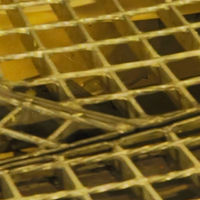

In [219]:
crop = img_infos['list_crops'][20000]
result = load_crop(crop,img_infos['paths'][crop[0]])
show_thumbnail(result)

### Affichage interactif de crops

In [220]:
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact
from matplotlib.pyplot import imshow 
import matplotlib.image as mpimg
import numpy as np


In [ ]:
np.ones(len([2,3]),dtype=np.)

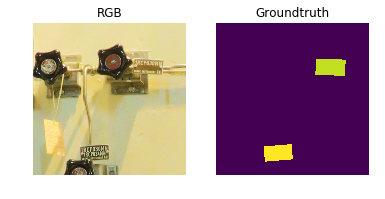

In [228]:
def func():
    n = len(img_infos['crops_with_labels'])
    def view_image(crop=264):
        i=crop
    #     crop = img_infos['list_crops'][i]
        crop = img_infos['list_crops'][img_infos['crops_with_labels'][i]]
        result = load_crop(crop,img_infos['paths'][crop[0]])
        result_mask = load_crop_mask(crop,img_infos['mask_paths'][crop[0]])
#         plt.title('title')
        plt.subplot(1, 2, 1) #ligne colonne
        plt.imshow(result)
        plt.title('RGB')
        plt.axis('off')
        plt.subplot(1, 2, 2) #ligne colonne
        plt.imshow(result_mask)

        plt.title('Groundtruth')
        plt.axis('off')

    interact(view_image, i=(0,n-1))
func()

### Construction du mask pour le training de Mask RCNN

In [229]:
i=264
crop = img_infos['list_crops'][img_infos['crops_with_labels'][i]]
result = load_crop(crop,img_infos['paths'][crop[0]])
result_mask = load_crop_mask(crop,img_infos['mask_paths'][crop[0]])

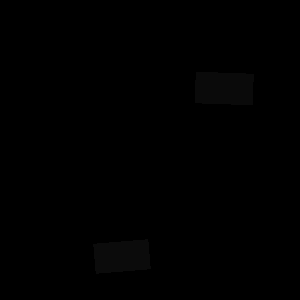

In [230]:
pil_resize(result_mask,300)

[10, 11]
shape (600, 600, 2)


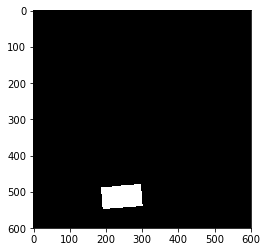

In [252]:
i=img_infos['crops_with_labels'][264]
crop = img_infos['list_crops'][i]
result = load_crop(crop,img_infos['paths'][crop[0]])
result_mask = load_crop_mask(crop,img_infos['mask_paths'][crop[0]])

result_mask_np = np.asarray(result_mask)
instances = np.unique(result_mask_np)
instances = [instance for instance in instances if instance>0]
print(instances)
mask_instance = 0*np.ndarray(shape=(*result_mask_np.shape,len(instances)),dtype=np.uint8)
print('shape',mask_instance.shape)
for instance_id,instance in enumerate(instances):
    mask_instance[:,:,instance_id]=(result_mask_np==instance).astype(np.uint8)
    
imgplot = plt.imshow(mask_instance[:,:,1],cmap='gray')

### Affichages d'un extrait d'image

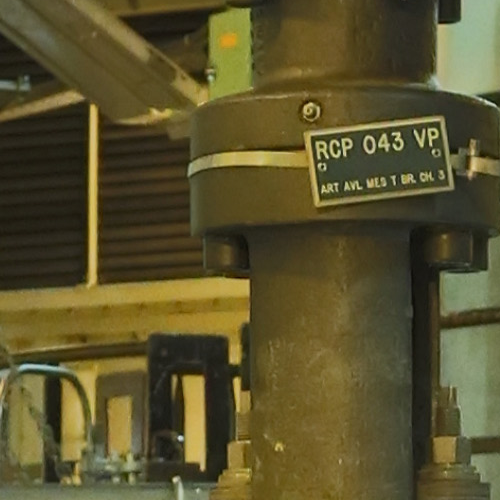

In [244]:
#(960, 230)
x = 7500
y = 16000
h = 500
w = 500

img_path = '/dds/work/workspace/data_ja/CAT_1_9013.jpg.ppm'
result = read_from_memory(img_path,x,y,w, h)
show_thumbnail(result,500)